In [26]:
from ProbRobNLP.dep_parsing import Sentence, parse_sentence, SubstitutionRule, substitution, compose
from ProbRobNLP.logic import *

The most important actual function in the **dep_parsing** module is **parse_sentence**. This function takes a sentence, parses in and returns a dictionary which contains the following keys:
    
    id: the position of the word
    word: the word itself (could potentially be several words after some processing has been done)
    tag: a POS tag
    pos: a different POS tag (not entirly sure what the difference between the tagsets are, check Spacy)
    dep: the dependency tag
    head: the id of the head of the sentence
    ref: I think currently not utilised
    word_positions: the id position of all words contained in word (used to combine different sub sentences in the correct way)
    sem: the semantics (DRSish) representation of the sentence
    
The key element here is "sem" as it contains the semantic representation of the sentence. This will be used downstream in the system. the tag and pos entries will correspond to the root word's pos-tags. 

In [7]:
parse_sentence("put a green tray on the table")

{'id': 0,
 'word': 'put a green tray on the table',
 'tag': 'VB',
 'dep': 'ROOT',
 'pos': 'VERB',
 'head': 0,
 'ref': {},
 'word_positions': (0, 1, 2, 3, 4, 5, 6),
 'sem': [x0, e0, X5, e1][green(x0), put(e0, x0, x0), on(e1, x0, X5), table(X5), tray(x0)] h: {} f: {}}

In this notebook we will look at how this function does this and how to expand the vocabulary and function of this function

The first step is to do a dependency parse using Spacy. This is done through the Sentence class.  The __init__ method will parse the sentence and returns a dictionary where the keys are the position of the word in each sentence and the value is another dictionary. This dictionary contains the following keys:
    
    id: the position of the word
    word: the word itself (could potentially be several words after some processing has been done)
    tag: a POS tag
    pos: a different POS tag (not entirly sure what the difference between the tagsets are, check Spacy)
    dep: the dependency tag
    head: the id of the head of the sentence
    ref: I think currently not utilised
    word_positions: the id position of all words contained in word (used to combine different sub sentences in the correct way)
 
 Note that these are equivalent to the ultimate output entry but without the "sem" key. 

In [8]:
print(s := Sentence("put a green tray on the table"))

0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0]}
1: {'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 3, 'ref': {}, 'word_positions': [1]}
2: {'id': 2, 'word': 'green', 'tag': 'JJ', 'dep': 'amod', 'pos': 'ADJ', 'head': 3, 'ref': {}, 'word_positions': [2]}
3: {'id': 3, 'word': 'tray', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0, 'ref': {}, 'word_positions': [3]}
4: {'id': 4, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 0, 'ref': {}, 'word_positions': [4]}
5: {'id': 5, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6, 'ref': {}, 'word_positions': [5]}
6: {'id': 6, 'word': 'table', 'tag': 'NN', 'dep': 'pobj', 'pos': 'NOUN', 'head': 4, 'ref': {}, 'word_positions': [6]}


The sentence class has various useful properties for navigating the dependency tree and updating the sentence structure in ways I've found helpful while working with the structure

In [9]:
print(f"You can get the root of the sentence: \n>>>s.get_root()\n{s.get_root()}\n")
print(f"This is equivalent to getting the head of the sentence\n>>>s.get_head()\n{s.get_head()}\n")
print(f"You can get all leaves of the dependency tree\n>>>s.get_leaves()\n{s.get_leaves()}\n")
print(f"You can also get the children of a particular word\n>>>s.get_children(0)\n{s.get_children(0)}")

You can get the root of the sentence: 
>>>s.get_root()
{'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0]}

This is equivalent to getting the head of the sentence
>>>s.get_head()
{'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0]}

You can get all leaves of the dependency tree
>>>s.get_leaves()
[{'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 3, 'ref': {}, 'word_positions': [1]}, {'id': 2, 'word': 'green', 'tag': 'JJ', 'dep': 'amod', 'pos': 'ADJ', 'head': 3, 'ref': {}, 'word_positions': [2]}, {'id': 5, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6, 'ref': {}, 'word_positions': [5]}]

You can also get the children of a particular word
>>>s.get_children(0)
[{'id': 3, 'word': 'tray', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0, 'ref': {}, 'word_positions': [3]}, {'id': 4, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'po

I've also added support for various getting and setting of values roughly equivalent to those expected of a standard dictionary and allow iteration over the sentence through the dictionary .items() function. 

However, one of the vital functions for the Sentence class is .join(head_id, child_id). This function allows us to merge the entries for a head and a child such that we keep track of the words included in the head and child of this sentence but we only keep one entry and we assume that the semantics of both entries are captured in the head. This allows us to recursively combine words until we have a single sentence.


In [10]:
s = Sentence('put a red tray on the table')
print(s)
print()
while len(s.get_leaves()) > 0:
    leaf = s.get_leaves()[0]
    head_id = leaf['head']
    child_id = leaf['id']
    print(f'Joining words {head_id} and {child_id}')
    s.join(head_id, child_id)
    
    
    print(s)
    print()

0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0]}
1: {'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 3, 'ref': {}, 'word_positions': [1]}
2: {'id': 2, 'word': 'red', 'tag': 'JJ', 'dep': 'amod', 'pos': 'ADJ', 'head': 3, 'ref': {}, 'word_positions': [2]}
3: {'id': 3, 'word': 'tray', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0, 'ref': {}, 'word_positions': [3]}
4: {'id': 4, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 0, 'ref': {}, 'word_positions': [4]}
5: {'id': 5, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6, 'ref': {}, 'word_positions': [5]}
6: {'id': 6, 'word': 'table', 'tag': 'NN', 'dep': 'pobj', 'pos': 'NOUN', 'head': 4, 'ref': {}, 'word_positions': [6]}

Joining words 3 and 1
0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0]}
2: {'id': 2, 'word': 'red', 'tag': 'JJ', 'dep': 'amod',

Now that we know a bit more about Sentences lets move on to look at how we go from the dependency parse to a semantic representation. To do that let's first look at the way we represent semantics, through the class DRSish. 

The DRSish class represents a DRS structure where we have a list of referents, a list of logical expressions (Atoms) and potentially some holes that need to be filled. 

First we set up a few different functions simply for generating variables. The purpose of these functions is to generate uniquely named variables which can be used inside of the DRSes. The way they function is through keeping global variables which are incremented each time a new variable is created. So the first variable will be named 'x0', the second 'x1' etc. The reset_X() functions reset this global counter which could be used for new dialogues or simply to keep the numbers low when experimenting in a notebook and re-running the same cells over and over. 

In [11]:
reset_reference()
reset_variable()
reset_event()
reset_event_variable()

x0 = get_reference()

e0 = get_event()
e1 = get_event()
E0 = get_event_variable()

X0 = get_variable()
X1 = get_variable()
X2 = get_variable()
X3 = get_variable()
X4 = get_variable()
X5 = get_variable()
X6 = get_variable()

This example shows the general method of creating a DRS instance with a particular example in mind. The idea is that we are composing the sub phrase 'a cup' together. We define the semantics of 'a' simply as a DRS with a single referent \['x0'\] and no logical expressions in the body. Note that lower case represents a constant, i.e. a specific object. Thus semantically we are saying that 'a' introduces a new referent 'x0'. 

Looking at 'cup' we now must create an Atom which is a filled logical expression. It is made up of a Predicate which has a name and an arity, so in this case Cup/1, and a list of terms populating the predicate, in this case just X0. This results in the atom Cup(X0). 

To make a DRS out of 'Cup' we have the referent be the variable X0 and we include the cup atom we created earlier. 

Now, to compose these two atoms from separate meanings of a and cup into the combined 'a cup' we have a method called 'join_on_reference'. This method assumes two DRSes with the same number of referents and simply puts equal signs between them meaning that x0 = X0 (note capitalisation). Practially this is implemented so that one of the two will replace the other. In particular it is the one which the method is called from. Note the difference between a.join_on_reference(cup) and cup.join_on_reference(a)

For the logical expressions, when we join on reference the lists are simply added together. 

In [14]:
cup_atom = Atom(Predicate('Cup', 1), [X0])

a = DRSish([x0], [])
cup = DRSish([X0], [cup_atom])
print(a)
print(cup)

print('correct way:', a.join_on_reference(cup))
print('incorrect way:', cup.join_on_reference(a))

[x0][] h: {} f: {}
[X0][Cup(X0)] h: {} f: {}
correct way: [x0][Cup(x0)] h: {} f: {}
incorrect way: [X0][Cup(X0)] h: {} f: {}


Another way of joinging two semantic representations is through the use of 'gaps' or 'holes'. Confusingly I've not been consistent with my usage of these as I have 'holes' and 'fill_gap'... Sorry...

A hole tells us what we expect to fill a variable with. So in Cup(X0) that variable is expected to take on a specific value. The hole: {'det': (X0, None)} tells us that we are expecting an determiner to give us a value for 'X0'. Ignore for now the second position in the tuple, it will be used later for 'control'. 

The 'det' tag is a dependency label where we expect an edge from e.g. 'a' to 'cup' with the label 'det'. 

We can 'fill' this 'gap' using the function of the same name. When we do so we specify the label of the edge we're trying to fill and the drs which is meant to fill that gap. When filling the gap the variable in the first element of the tuple is equated to the first referent in the filling DRS (so X0 is filled with a.ref\[0\] which is x0). 

We see below how this results in the DRS we expect for composing a and cup

In [16]:
a = DRSish([x0], [])
cup = DRSish([X0], [cup_atom], holes={'det':(X0, None)})
print(a)
print(cup)

print(a_cup := cup.fill_gap(a, 'det'))


[x0][] h: {} f: {}
[X0][Cup(X0)] h: {'det': (X0, None)} f: {}
[x0][Cup(x0)] h: {} f: {}


Below we extend the example to show how we can use these different functions to join together DRSs

In [17]:

blue_atom = Atom(Predicate('Blue', 1), [X1])
table_atom = Atom(Predicate('Table', 1), [X5])

the = DRSish([X2], [])
blue = DRSish([X1], [blue_atom])
table = DRSish([X5], [table_atom], holes={'det':(X5, None)})




on_atom = Atom(Predicate('On', 2), [X3, X4])

on = DRSish([X3, X4], [on_atom], holes={'dobj': (X3, None), 'pobj': (X4, None)})

print(blue_table := blue.join_on_reference(table))

print(the_blue_table := blue_table.fill_gap(the, 'det'))

print(a_cup_on := on.fill_gap(a_cup, 'dobj'))

print(a_cup_on_the_blue_table := a_cup_on.fill_gap(the_blue_table, 'pobj'))


[X1][Table(X1), Blue(X1)] h: {'det': (X1, None)} f: {}
[X2][Blue(X2), Table(X2)] h: {} f: {}
[X4, x0][On(x0, X4), Cup(x0)] h: {'pobj': (X4, None)} f: {}
[x0, X2][Blue(X2), On(x0, X2), Table(X2), Cup(x0)] h: {} f: {}


In the following example we try to compose the sentence 'put a cup on the blue table'. Here we introduce event variables for verbs and prepositions. This brings it more in line with linguistic theory and makes events make a bit more sense. 

Now, the crucial newly introduced element is 'control'. Now, the idea here is that in some cases you will have a dependency graph where a variable is defined in one place but is not a child of a different predicate which actually needs to fill in that same variable. This is the case with 'on' in the sentence below. We can see that 'put' is the head of the sentence and has 'a cup' as the dobj and 'on the blue table' connects (via on) as a 'prep'. In our semantics we would like 'on' to be fillwed with 'on(x1, x2)' where x1 is the entity introduced by 'a cup' and x2 is the entity referenced by 'the blue table'. In order to make this work we somehow need to tell 'on' what the referent from 'a cup' is and if we are just combining things upwards in the dependency tree we wouldn't be able to do that. 

Thus we introduce the concept of 'control'. Basically what this does is allows us to fill a gap belonging to something lower down in the tree. So when we see the 'prep' label, we know that there's an event E1 we need to fill, but also, we are saying with ('control', X6) that we are expecting the child node to have a hole called 'control' and we will fill that gap with X6. 


In [18]:
Sentence('put a cup on the blue table')

0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0]}
1: {'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 2, 'ref': {}, 'word_positions': [1]}
2: {'id': 2, 'word': 'cup', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0, 'ref': {}, 'word_positions': [2]}
3: {'id': 3, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 0, 'ref': {}, 'word_positions': [3]}
4: {'id': 4, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6, 'ref': {}, 'word_positions': [4]}
5: {'id': 5, 'word': 'blue', 'tag': 'JJ', 'dep': 'amod', 'pos': 'ADJ', 'head': 6, 'ref': {}, 'word_positions': [5]}
6: {'id': 6, 'word': 'table', 'tag': 'NN', 'dep': 'pobj', 'pos': 'NOUN', 'head': 3, 'ref': {}, 'word_positions': [6]}

In [21]:


on_atom = Atom(Predicate('On', 3), [e1, X3, X4])

put_atom = Atom(Predicate('Put', 3), [e0, X6, E0])

on = DRSish([e0, X3, X4], [on_atom], holes={'control': (X3, None), 'pobj': (X4, None)})

put = DRSish([e1, X6, E0], [put_atom], holes={'dobj': (X6, None), 'prep': (E0, ('control', X6))})

print(on_the_blue_table := on.fill_gap(the_blue_table, 'pobj'))

print(put_a_cup := put.fill_gap(a_cup, 'dobj'))

print(put_a_cup_on_the_blue_table := put_a_cup.fill_gap(on_the_blue_table, 'prep'))

[X3, e0, X2][On(e1, X3, X2), Blue(X2), Table(X2)] h: {'control': (X3, None)} f: {}
[e1, e0, x0][Put(e0, x0, e0), Cup(x0)] h: {'prep': (e0, ('control', x0))} f: {}
[x0, X2, e0, e1][Put(e0, x0, x0), On(e1, x0, X2), Cup(x0), Blue(X2), Table(X2)] h: {} f: {}


This concludes the theory of our DRS functions. Now we shall look how we use these to build a grammar and to generate logical forms from sentences parsed by Spacy. 

The first step is substitution. In this step we create rules for giving a semantic representation to a word based on its part of speech, the word itself, or whatever other factors we wish. 

To do this we define a SubstitutionRule. The rule has a name, a checking function which identifies if the rule applies to a particular word, and finally a semantic function which returns the DRS for the word. 

The checking function must return a boolean and take three inputs: an id (the position of the word in the sentence), the word (as defined by a Sentence) and the sentence as a whole. The semantic function just has to take the word and return a DRSish. 

In [22]:
s = Sentence('put a green cup on the tray')

In [23]:
a_rule = SubstitutionRule('a', lambda id_, w, s: w['word'] == 'a', lambda w: DRSish([get_variable()], []))


In [24]:
a_rule.apply(1, s[1], s)

[X7][] h: {} f: {}

After substitution we compose word positions together using the compose function. This function takes the current sentence and a position. The word on that position is composed with its head. The intended use is to take leaves of the dependency tree and compose them with their heads until only a single element remains.  

In [27]:
reset_reference()
reset_variable()
reset_event()
reset_event_variable()

s = Sentence('put a green cup on the tray')
print(sub_s := substitution(s))
print()
print(sub_s := compose(sub_s, 5))
print()
print(sub_s := compose(sub_s, 6))
print()
print(sub_s := compose(sub_s, 2))
print()
print(sub_s := compose(sub_s, 1))
print()
print(sub_s := compose(sub_s, 3))
print()
print(sub_s := compose(sub_s, 4))


0: {'id': 0, 'word': 'put', 'tag': 'VB', 'dep': 'ROOT', 'pos': 'VERB', 'head': 0, 'ref': {}, 'word_positions': [0], 'sem': [e0][put(e0, X0, e0)] h: {'dobj': (X0, None), 'prep': (e0, ('control', X0))} f: {}}
1: {'id': 1, 'word': 'a', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 3, 'ref': {}, 'word_positions': [1], 'sem': [x0][] h: {} f: {}}
2: {'id': 2, 'word': 'green', 'tag': 'JJ', 'dep': 'amod', 'pos': 'ADJ', 'head': 3, 'ref': {}, 'word_positions': [2], 'sem': [X1][green(X1)] h: {} f: {}}
3: {'id': 3, 'word': 'cup', 'tag': 'NN', 'dep': 'dobj', 'pos': 'NOUN', 'head': 0, 'ref': {}, 'word_positions': [3], 'sem': [X2][cup(X2)] h: {} f: {}}
4: {'id': 4, 'word': 'on', 'tag': 'IN', 'dep': 'prep', 'pos': 'ADP', 'head': 0, 'ref': {}, 'word_positions': [4], 'sem': [e1, X3, X4][on(e1, X3, X4)] h: {'control': (X3, None), 'pobj': (X4, None)} f: {}}
5: {'id': 5, 'word': 'the', 'tag': 'DT', 'dep': 'det', 'pos': 'DET', 'head': 6, 'ref': {}, 'word_positions': [5], 'sem': [X5][] h: {} f: {}}
6: {'i

The functionality shown above is done automatically by the 'parse_sentence' function. It uses Spacy to get a dependency parse and then substitutes and then composing by taking some leaf of the dependency tree until there's just the one entry left. 

In [28]:
parse_sentence('put a green cup on the tray')

{'id': 0,
 'word': 'put a green cup on the tray',
 'tag': 'VB',
 'dep': 'ROOT',
 'pos': 'VERB',
 'head': 0,
 'ref': {},
 'word_positions': (0, 1, 2, 3, 4, 5, 6),
 'sem': [X12, x1, e3, e2][tray(X12), cup(x1), put(e2, x1, e3), green(x1), on(e3, x1, X12)] h: {} f: {}}

Finally, we'll look at how this is brought together to perform the full dialogue. We have a dialogue class with an update function. When a sentence is passed to the update function it uses the parse_sentence function to generate a semantic representation. Next the system does co-reference resolution. Currently this is done through a rule based method where the system checks various constraints to see which references can be refered to by an expression. E.g. 'the table' can only refer to 'a blue table' because there are no other tables. Currently, if there is ambiguity this will not be resolved properly by the system (I was working on this when I quit and so I am unsure exactly where to I got in this process). The final step is a rulebased method for turning the DRSish representation into prob rob scene code. The example below shows the PRS code that has been generated after each sentence. The draw function samples a scene and draws it in matplotlib. 

In [30]:
from ProbRobNLP.dialogue import *

put a blue table on the centre
from model import *
x0 = Table with color "blue", on Vector3D(0, 0, 0)

put a green tray on the table
from model import *
x0 = Table with color "blue", on Vector3D(0, 0, 0)
x1 = Tray on x0, with color "green"

put a red tray to the left of the tray
from model import *
x0 = Table with color "blue", on Vector3D(0, 0, 0)
x1 = Tray on x0, with color "green"
x2 = Tray with color "red", left of x1

the red tray should be on the table
from model import *
x0 = Table with color "blue", on Vector3D(0, 0, 0)
x1 = Tray on x0, with color "green"
x2 = Tray on x0, with color "red", left of x1


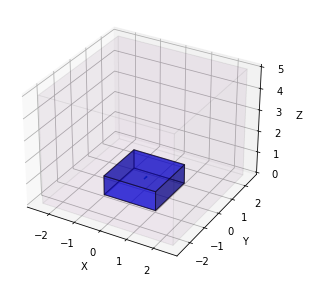

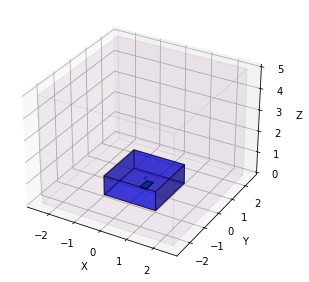

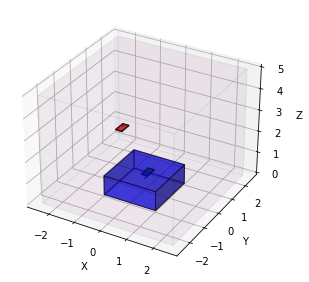

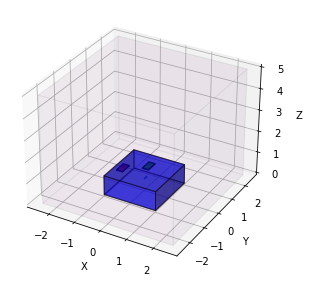

In [32]:
dlg = Dialogue()

print(s := "put a blue table on the centre")
dlg.update(s)
dlg.draw(max_generations=1)
print()
print(s :="put a green tray on the table")
dlg.update(s)
dlg.draw(max_generations=1)
print()
print(s :="put a red tray to the left of the tray")
dlg.update(s)
dlg.draw(max_generations=1)
print()
print(s :="the red tray should be on the table")
dlg.update(s)
dlg.draw(max_generations=1)